# Prototype calculation of cabelling and mixing of density from CM2.6 data <a class="anchor" id="top"> </a>
## Table Of Contents: 
* [Calculate tendency of SST and and SSS from mixing](#first-bullet)
* [Convert to density tendency](#second-bullet)
* [Decompose into the following form](#third-bullet)
* [Save the four terms to dataset](#fourth-bullet)

(Next steps are continued in [tendency-histograms.ipynb](./tendency-histograms.ipynb)

In [69]:
from dask_gateway import Gateway
gateway = Gateway()
options = gateway.cluster_options()

# set the options programatically, or through their HTML repr
options.worker_memory = 30  # 10 GB of memory per worker.

# Create a cluster with those options
cluster = gateway.new_cluster(options)
cluster.scale(30)
client = cluster.get_client()

In [10]:
from dask_gateway import Gateway
g = Gateway()
cluster = g.connect(g.list_clusters()[0].name)
client = cluster.get_client()

In [11]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.1321f186a83e47eea1c2c276474aa66c/status,


In [19]:
cluster.close()
client.close()

In [1]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
from fastjmd95 import jmd95numba
import pop_tools
import gcsfs
import gcm_filters
import xgcm

In [2]:
from intake import open_catalog

url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/GFDL_CM2.6.yaml"
cat = open_catalog(url)
ds  = cat["GFDL_CM2_6_control_ocean"].to_dask()
coord  = cat["GFDL_CM2_6_grid"].to_dask()

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/coding/times.py:710: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


In [3]:
ds

<xarray.Dataset>
Dimensions:            (time: 240, yt_ocean: 2700, xt_ocean: 3600,
                        yu_ocean: 2700, xu_ocean: 3600, nv: 2, st_ocean: 50,
                        st_edges_ocean: 51, sw_edges_ocean: 51, sw_ocean: 50)
Coordinates: (12/14)
    geolat_c           (yu_ocean, xu_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t           (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_c           (yu_ocean, xu_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t           (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * nv                 (nv) float64 1.0 2.0
  * st_edges_ocean     (st_edges_ocean) float64 0.0 10.07 ... 5.29e+03 5.5e+03
    ...                 ...
  * sw_ocean           (sw_ocean) float64 10.07 20.16 30.29 ... 5.29e+03 5.5e+03
  * time               (time) object 0181-01-16 12:00:00 ... 0200-12-16 12:00:00
  * xt_ocean           (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.85 79.95
  * xu_ocean           (xu_ocean) float64 -279.9 -279.8 -279.7 ... 79.9 80.0
  * yt_ocean           (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.94 89.98
  * yu_ocean           (yu_ocean) float64 -81.09 -81.05 -81.0 ... 89.96 90.0
Data variables: (12/31)
    average_DT         (time) timedelta64[ns] dask.array<chunksize=(12,), meta=np.ndarray>
    average_T1         (time) object dask.array<chunksize=(12,), meta=np.ndarray>
    average_T2         (time) object dask.array<chunksize=(12,), meta=np.ndarray>
    eta_t              (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    eta_u              (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    frazil_2d          (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    ...                 ...
    temp_rivermix      (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 5, 2700, 3600), meta=np.ndarray>
    time_bounds        (time, nv) timedelta64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
    ty_trans           (time, st_ocean, yu_ocean, xt_ocean) float32 dask.array<chunksize=(1, 5, 2700, 3600), meta=np.ndarray>
    u                  (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 5, 2700, 3600), meta=np.ndarray>
    v                  (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 5, 2700, 3600), meta=np.ndarray>
    wt                 (time, sw_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 50, 2700, 3600), meta=np.ndarray>
Attributes:
    filename:   01810101.ocean.nc
    grid_tile:  1
    grid_type:  mosaic
    title:      CM2.6_miniBling

In [4]:
list(gcm_filters.GridType)

[<GridType.REGULAR: 1>,
 <GridType.REGULAR_AREA_WEIGHTED: 2>,
 <GridType.REGULAR_WITH_LAND: 3>,
 <GridType.REGULAR_WITH_LAND_AREA_WEIGHTED: 4>,
 <GridType.IRREGULAR_WITH_LAND: 5>,
 <GridType.MOM5U: 6>,
 <GridType.MOM5T: 7>,
 <GridType.TRIPOLAR_REGULAR_WITH_LAND_AREA_WEIGHTED: 8>,
 <GridType.TRIPOLAR_POP_WITH_LAND: 9>,
 <GridType.VECTOR_C_GRID: 10>]

In [5]:
gcm_filters.required_grid_vars(gcm_filters.GridType.MOM5T)

['wet_mask', 'dxt', 'dyt', 'dxu', 'dyu', 'area_t']

In [6]:
hfacc = ds.temp.where(ds.temp == ds.temp.notnull(), 999).where(ds.temp < 999, 111)
mask = hfacc==999

In [7]:
wet_mask = mask[0,0]
dxt = coord.dxt
dyt = coord.dyt
dxu = coord.dxu
dyu = coord.dyu
area_t = coord.area_t

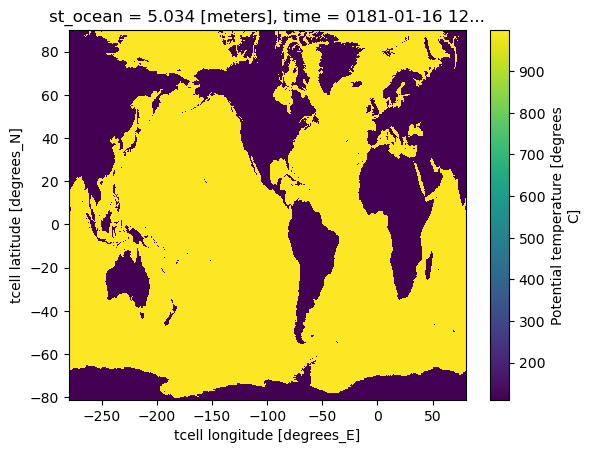

In [10]:
hfacc[0,0].plot()

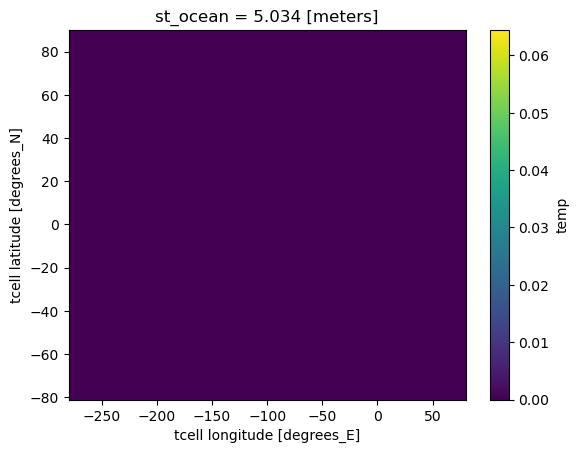

In [14]:
#checking if mask changes through time - it doesn't so define wetmask
mask.std('time')[0].plot()

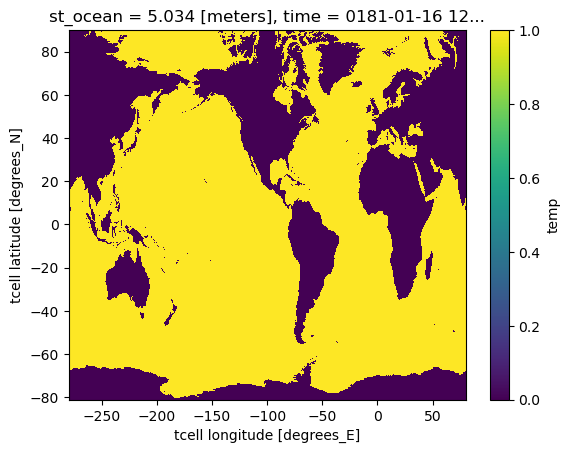

In [11]:
wet_mask.plot()

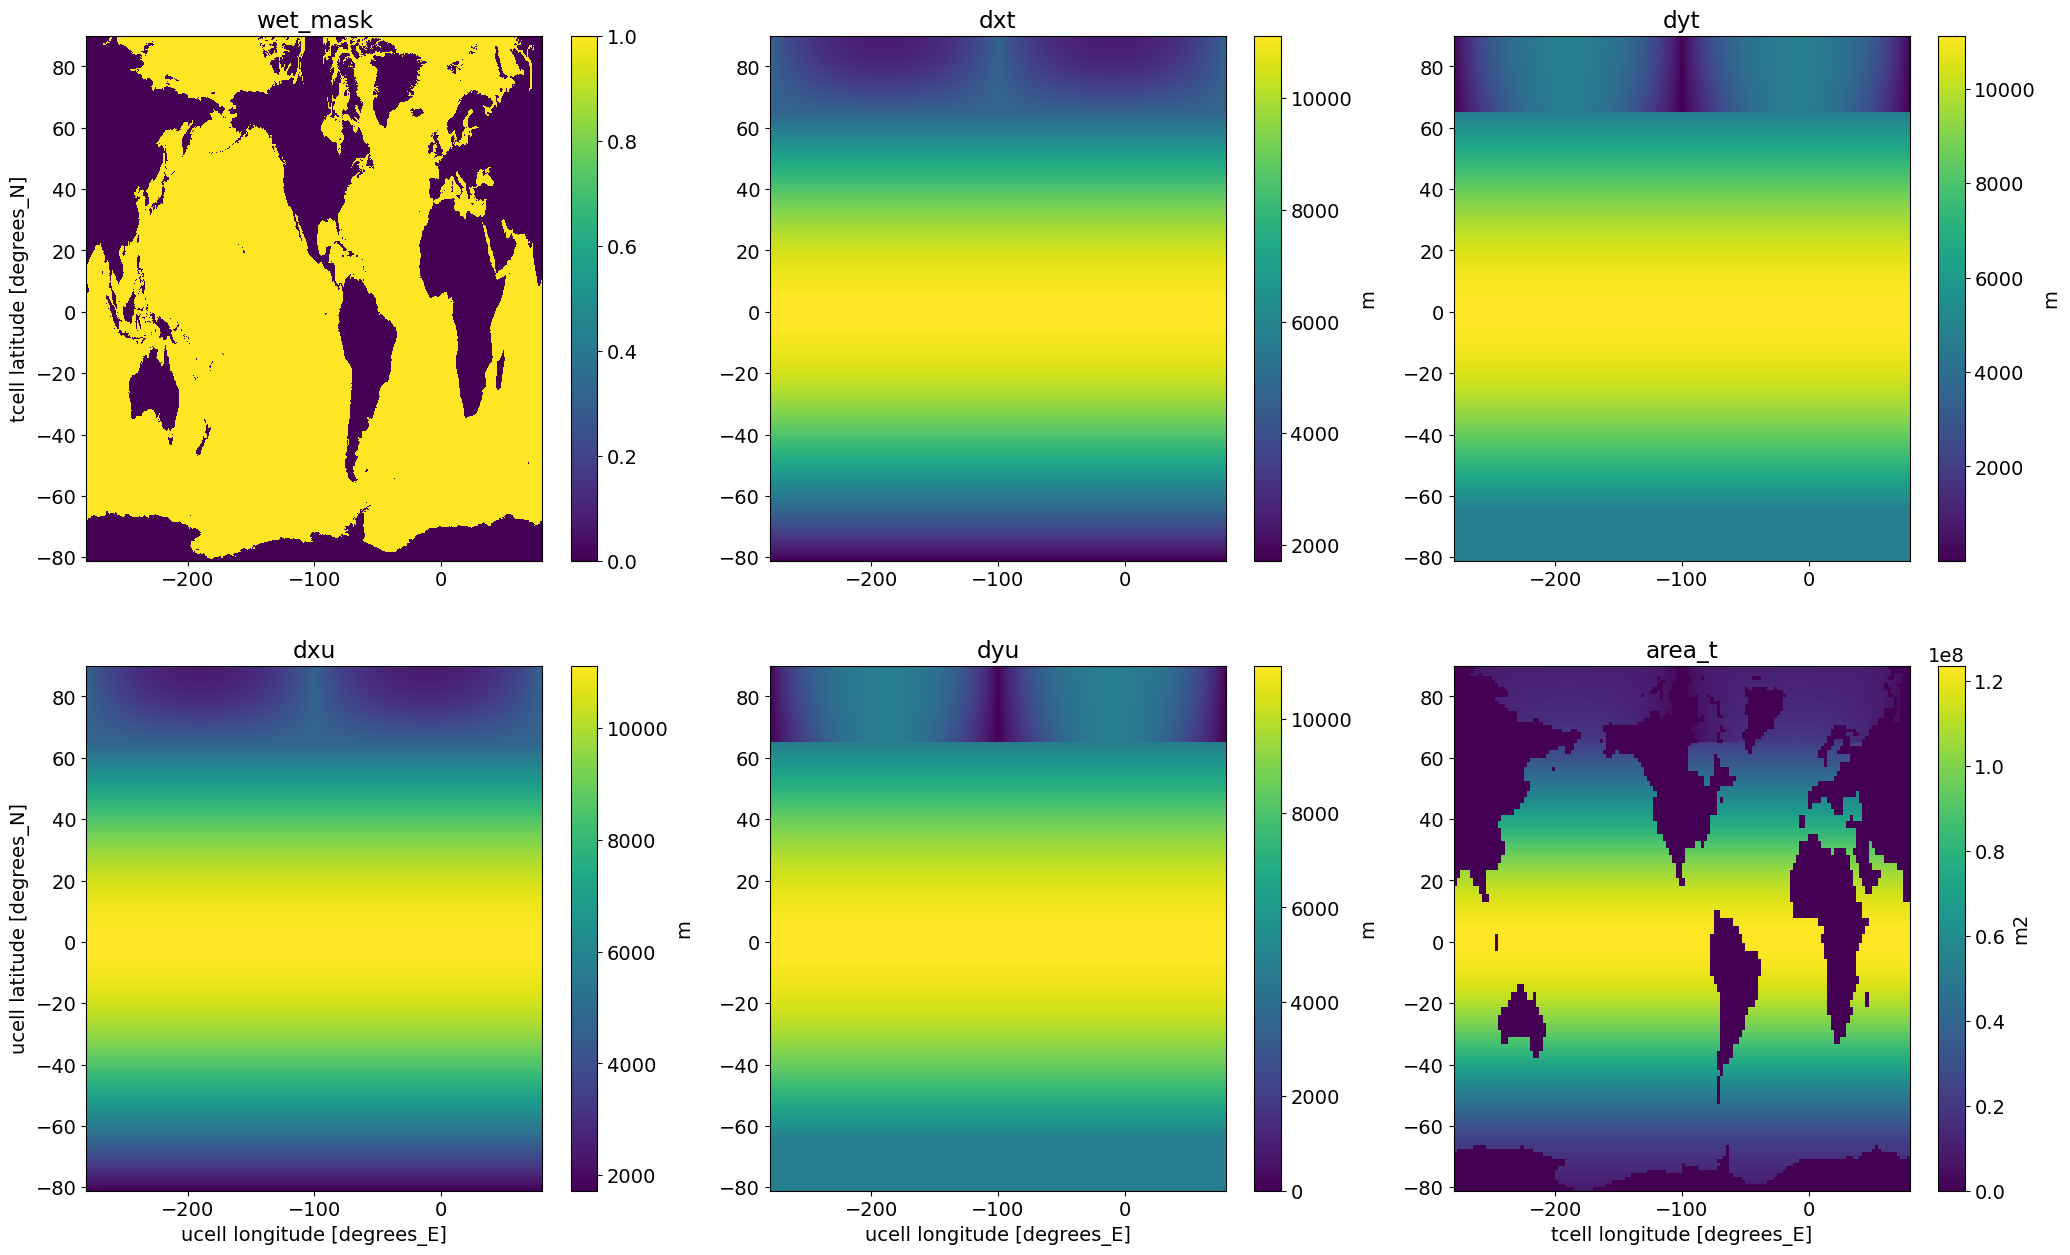

In [28]:
import matplotlib.pylab as pylab
params = {'font.size': 14}
pylab.rcParams.update(params)

fig,axs = plt.subplots(2,3,figsize=(25,15))
wet_mask.plot(ax=axs[0,0], cbar_kwargs={'label': ''})
axs[0,0].set(title='wet_mask', xlabel='')
dxt.plot(ax=axs[0,1], cbar_kwargs={'label': 'm'})
axs[0,1].set(title='dxt', xlabel='', ylabel='')
dyt.plot(ax=axs[0,2], cbar_kwargs={'label': 'm'})
axs[0,2].set(title='dyt', xlabel='', ylabel='')
dxu.plot(ax=axs[1,0], cbar_kwargs={'label': 'm'})
axs[1,0].set(title='dxu')
dyu.plot(ax=axs[1,1], cbar_kwargs={'label': 'm'})
axs[1,1].set(title='dyu', ylabel='')
area_t.plot(ax=axs[1,2], cbar_kwargs={'label': 'm2'})
axs[1,2].set(title='area_t', ylabel='');

In [10]:
dxt.min().values

array(1718.64599027)

In [35]:
dyt.min().values

array(4.10350358)

In [36]:
dxu.min().values

array(1722.6953525)

In [37]:
dyu.min().values

array(2.88051292e-13)

In [32]:
dx_min = min(dxt.min(),dyt.min(),dxu.min(),dyu.min())
dx_min = dx_min.values
dx_min

array(2.88051292e-13)

In [45]:
dxt.where(wet_mask).min().values

array(1831.93785406)

In [36]:
grid = xgcm.Grid(ds, coords={'X': {'center': 'xt_ocean', 'right': 'xu_ocean'},
                        'Y': {'center': 'yt_ocean', 'right': 'yu_ocean'},
                        'Z': {'inner': 'st_ocean', 'outer': 'st_edges_ocean'} }, periodic=['X'])

In [39]:
dxu_interp = grid.interp(dxu, ['X','Y'], boundary='fill')
dyu_interp = grid.interp(dyu, ['X','Y'], boundary='fill')

In [41]:
filter_scale = 10000
dx_min = dxt.min().values #dxt.where(wet_mask).min().values #dxmin
# -- initialze filter object for two filter types -- 
specs = {
    'filter_scale': filter_scale,
    'dx_min': dx_min,
    'grid_type': gcm_filters.GridType.MOM5T,
    'grid_vars': {'wet_mask': wet_mask.drop(['geolat_t', 'geolon_t']), 'dxt':dxt, 'dyt':dyt, 
                  'dxu':dxu_interp, 'dyu':dyu_interp, 'area_t': area_t},
}
# GAUSSIAN 
filter_simple_fixed_factor_G = gcm_filters.Filter(filter_shape=gcm_filters.FilterShape.GAUSSIAN, **specs)
# TAPER 
filter_simple_fixed_factor_T = gcm_filters.Filter(filter_shape=gcm_filters.FilterShape.TAPER, **specs)

In [42]:
sst_filtered = filter_simple_fixed_factor_G.apply(ds.temp.isel(time=0, st_ocean=0).drop(['geolat_t', 'geolon_t']),
                                                  dims=['yt_ocean', 'xt_ocean']) # apply filter lazily
sst_filtered.data

dask.array<transpose, shape=(2700, 3600), dtype=float32, chunksize=(2700, 3600), chunktype=numpy.ndarray>

In [43]:
sst_filtered.compute()

/srv/conda/envs/notebook/lib/python3.10/site-packages/gcm_filters/kernels.py:418: RuntimeWarning: divide by zero encountered in divide
  out1 /= self.area_t
/srv/conda/envs/notebook/lib/python3.10/site-packages/gcm_filters/kernels.py:418: RuntimeWarning: invalid value encountered in divide
  out1 /= self.area_t
/srv/conda/envs/notebook/lib/python3.10/site-packages/gcm_filters/kernels.py:424: RuntimeWarning: invalid value encountered in divide
  out2 /= self.area_t


<xarray.DataArray (yt_ocean: 2700, xt_ocean: 3600)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    st_ocean  float64 5.034
    time      object 0181-01-16 12:00:00
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    area_t    (yt_ocean, xt_ocean) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    dyt       (yt_ocean, xt_ocean) float64 4.697e+03 4.697e+03 ... 23.38 7.804
    geolat_t  (yt_ocean, xt_ocean) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    geolon_t  (yt_ocean, xt_ocean) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ht        (yt_ocean, xt_ocean) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    kmt       (yt_ocean, xt_ocean) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    wet       (yt_ocean, xt_ocean) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    dxt       (yt_ocean, xt_ocean) float64 1.719e+03 1.719e+03 ... 4.697e+03

In [49]:
ds.temp[0,0][0:45, -75:-25]

<xarray.DataArray 'temp' (yt_ocean: 45, xt_ocean: 50)>
dask.array<getitem, shape=(45, 50), dtype=float32, chunksize=(45, 50), chunktype=numpy.ndarray>
Coordinates:
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(45, 50), meta=np.ndarray>
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(45, 50), meta=np.ndarray>
    st_ocean  float64 5.034
    time      object 0181-01-16 12:00:00
  * xt_ocean  (xt_ocean) float64 72.55 72.65 72.75 72.85 ... 77.25 77.35 77.45
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -79.33 -79.29 -79.25
Attributes:
    cell_methods:   time: mean
    long_name:      Potential temperature
    standard_name:  sea_water_potential_temperature
    time_avg_info:  average_T1,average_T2,average_DT
    units:          degrees C
    valid_range:    [-10.0, 500.0]

In [54]:
ds.temp.xt_ocean

<xarray.DataArray 'xt_ocean' (xt_ocean: 3600)>
array([-279.95, -279.85, -279.75, ...,   79.75,   79.85,   79.95])
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
Attributes:
    cartesian_axis:  X
    long_name:       tcell longitude
    units:           degrees_E

/srv/conda/envs/notebook/lib/python3.10/site-packages/gcm_filters/kernels.py:418: RuntimeWarning: divide by zero encountered in divide
  out1 /= self.area_t
/srv/conda/envs/notebook/lib/python3.10/site-packages/gcm_filters/kernels.py:418: RuntimeWarning: invalid value encountered in divide
  out1 /= self.area_t
/srv/conda/envs/notebook/lib/python3.10/site-packages/gcm_filters/kernels.py:424: RuntimeWarning: invalid value encountered in divide
  out2 /= self.area_t


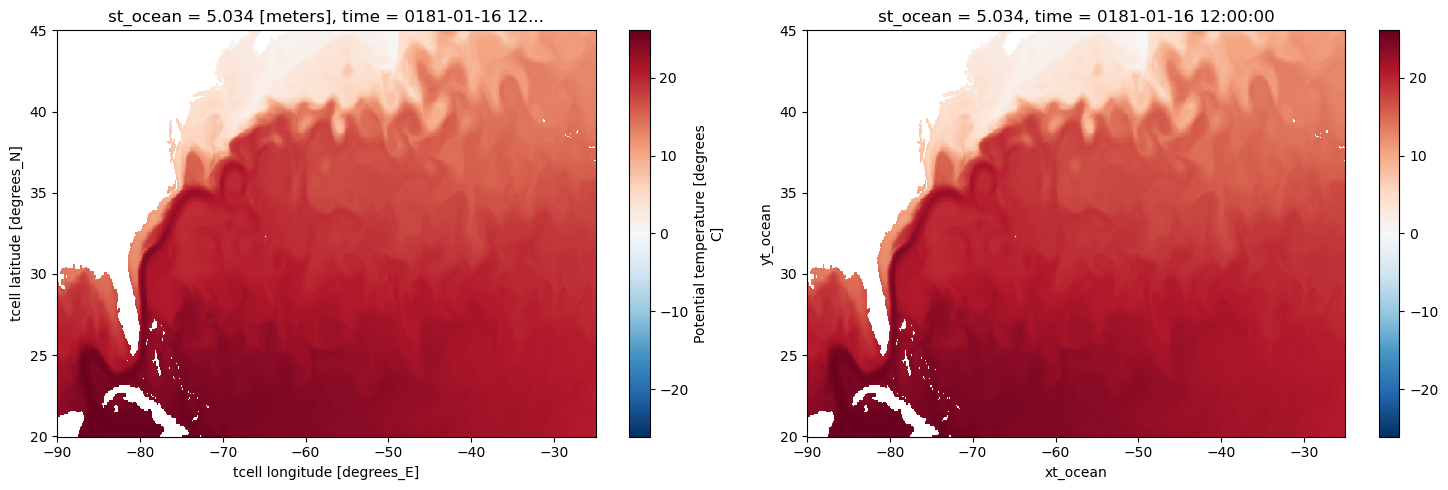

In [60]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,5))
selection = dict(yt_ocean=slice(20,45), xt_ocean=slice(-90, -25))
ds.temp[0,0].sel(**selection).plot(ax=ax0)
sst_filtered.sel(**selection).plot(ax=ax1)
plt.tight_layout();

# 1) Calculate tendency of SST and and SSS from mixing <a class="anchor" id="first-bullet"> </a>